# Plot model fit comparisons for simulation analysis 2

In [36]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mindstorm import statplot
from cfr import framework
from cfr import figures
from cfr import reports

# fit_dir = Path(os.environ['CFR_FITS'])
fit_dir = Path("/Users/morton/Dropbox/work/cmr_cfr/peers/fits/v5")
fig_dir = Path("/Users/morton/Dropbox/work/cmr_cfr/peers/figs/v1")
# fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

## Load model fits

In [22]:
# restricted models
model_dict = {
    "I": "cmrs_fcf-loc",
    "D": "cmrs_fcf-use",
    "ID": "cmrs_fcf-loc-use",
    # "UR": "cmrs_fcf-loc-use_sl-B_enc-B_rec",
    "RD": "cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_rec_use1",
    "ED-RD": "cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_enc_use1-B_rec_use1",
    "MP16": "cmrs_fcf-loc_ff-use",
}

subs_mapping = {
    "ID": "DCMR", 
    # "UR": "DCMR-Variable", 
    "RD": "DCMR-Restricted", 
    "ED-RD": "DCMR-NoSemDrift", 
    "MP16": "CMR MP16"
}
subs_dict = {long: model_dict[short] for short, long in subs_mapping.items()}

models = list(model_dict.values())
model_names = list(model_dict.keys())

subs = list(subs_dict.values())
subs_names = list(subs_dict.keys())

res = framework.read_model_xvals(fit_dir, models, model_names)
res.groupby('model')['logl_test_list'].mean().sort_values()

model
D       -23.307242
I       -21.962667
ID      -21.621330
ED-RD   -21.608065
MP16    -21.507783
RD      -21.457658
Name: logl_test_list, dtype: float64

## Plot model cross-validation performance

LINO NOT subset; don't know how to subset; dropped


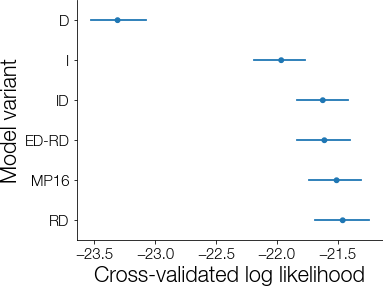

In [10]:
# plot cross-validation log-likelihood with within-subject error
res['deviation'] = figures.remove_subject_variance(
    res, 'logl_test_list', 'subject'
)
res['mean_deviation'] = res.groupby('model')['deviation'].transform('mean')
res_sorted = res.sort_values('mean_deviation').reset_index()
g = sns.catplot(
    data=res_sorted, 
    x='deviation', 
    y='model', 
    kind='point', 
    join=False, 
    aspect=1.3, 
    height=4.5,
)
g.set(xlabel='Cross-validated log likelihood', ylabel='Model variant')
g.savefig(fig_dir / 'model_comp_xval_full.pdf');

LINO NOT subset; don't know how to subset; dropped


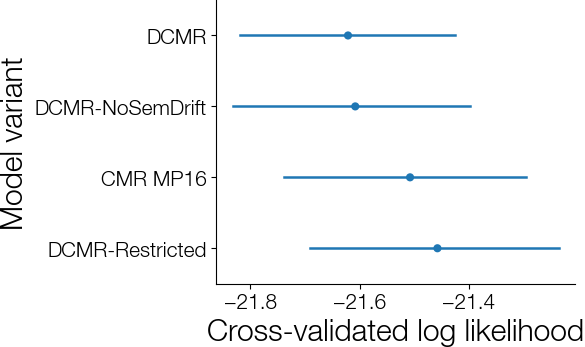

In [31]:
# plot cross-validation log-likelihood with within-subject error
sub = res.loc[subs_mapping.keys()].rename(index=subs_mapping)
sub['deviation'] = figures.remove_subject_variance(
    sub, 'logl_test_list', 'subject'
)
sub['mean_deviation'] = sub.groupby('model')['deviation'].transform('mean')
res_sorted = sub.sort_values('mean_deviation').reset_index()
g = sns.catplot(
    data=res_sorted, 
    x='deviation', 
    y='model', 
    kind='point', 
    join=False, 
    aspect=1.57, 
    height=4,
)
g.set(xlabel='Cross-validated log likelihood', ylabel='Model variant')
g.savefig(fig_dir / 'model_comp_xval_subset.pdf');

## Plot best-fitting B parameters by sublayer

In [32]:
dark = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=1, hue=.5'
)
dark

[(0.7689335648950519, 0.6824396172757954, 0.6240123846554909),
 (0.7250187127782463, 0.5677430873950093, 0.6103083104698684),
 (0.623013021104788, 0.4855809829815538, 0.6161810850461853),
 (0.464634733019296, 0.4332443294049108, 0.5801730795425324),
 (0.31355069957273196, 0.3965359745123169, 0.4760973803152319),
 (0.2050147315167219, 0.34168808481661433, 0.31762490490999895)]

In [33]:
light = sns.color_palette(
    'ch:start=1, rot=1.5, light=.7, dark=.3, gamma=.5, hue=1'
)
light

[(0.9248203983802259, 0.8124754066629261, 0.7365856230946308),
 (0.9370151046580671, 0.7134152392755648, 0.773930517001042),
 (0.8638347057562072, 0.6485629096614572, 0.8531332480304541),
 (0.6875944308206159, 0.6323388125763083, 0.8909732355818533),
 (0.4826946089121227, 0.6491392670198295, 0.8087166257388984),
 (0.325484389760949, 0.649366831333291, 0.5923429764853889)]

In [34]:
B_names = [
    'B_enc_loc',
    'B_enc_use',
    'B_rec_loc',
    'B_rec_use',
]
B_labels = [
    r'$\beta_\mathrm{enc}^{I}$',
    r'$\beta_\mathrm{enc}^{D}$',
    r'$\beta_\mathrm{rec}^{I}$',
    r'$\beta_\mathrm{rec}^{D}$',
]
B_subset = pd.melt(
    res.loc['UR', B_names].reset_index(),
    id_vars='subject', 
    value_vars=B_names,
    var_name='parameter',
    value_name='value',
)
B_subset['phase'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'enc',
        'B_enc_use': 'enc',
        'B_rec_loc': 'rec',
        'B_rec_use': 'rec',
    }
)
B_subset['sublayer'] = B_subset['parameter'].map(
    {
        'B_enc_loc': 'I',
        'B_enc_use': 'D',
        'B_rec_loc': 'I',
        'B_rec_use': 'D',
    }
)
fig, ax = plt.subplots(figsize=(6, 4))
statplot.plot_swarm_bar(
    B_subset,
    x='phase',
    y='value',
    hue='sublayer',
    point_kind='strip',
    light=light,
    dark=dark,
    dodge=True,
    bar_kws={'capsize': 0.2, 'clip_on': False},
    point_kws={'size': 4},
    legend=False,
    ax=ax,
)
ax.set(ylim=(0, 1), ylabel='Parameter estimate')
ax.set_xticks(
    [0, 1], 
    [r'$\beta_{enc}$', r'$\beta_{rec}$'], 
    usetex=True, 
    fontfamily='helvetica',
    fontsize='x-large',
)
ax.tick_params(axis='x', length=0)
ax.set(ylim=(0, 1.08), yticks=np.arange(0, 1.2, 0.2))
ax.spines['left'].set_bounds(0, 1)
fig.legend(loc=(.3375, .9), prop={'size': 12}, ncol=3)
ax.yaxis.set_label_coords(-.1, 0.475)
fig.savefig(fig_dir / 'param_B.pdf')

KeyError: 'UR'

## Create parameter tables

In [37]:
table = reports.create_model_table(fit_dir, models, model_names, model_comp='xval')
table.to_latex(fig_dir / 'parameters2_full.tex', escape=False)
table

/var/folders/9d/zh72ny012k7bvgr427k05d8w0000gn/T/ipykernel_48993/1659336159.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(fig_dir / 'parameters2_full.tex', escape=False)


,I,D,ID,RD,ED-RD,MP16
$L_{FC}$,0.26 (0.01),0.48 (0.01),0.22 (0.00),0.38 (0.01),0.27 (0.01),0.26 (0.01)
$L_{CF}$,0.39 (0.01),0.74 (0.01),0.33 (0.01),0.57 (0.01),0.40 (0.01),0.38 (0.01)
$D_{FF}$,---,---,---,---,---,0.20 (0.00)
$\phi_s$,0.48 (0.03),0.65 (0.01),0.20 (0.00),0.18 (0.00),0.16 (0.00),0.49 (0.03)
$\phi_d$,0.92 (0.03),0.72 (0.02),1.00 (0.03),0.87 (0.03),0.90 (0.04),0.89 (0.03)
$\beta_{\mathrm{enc}}$,0.53 (0.01),0.29 (0.01),0.54 (0.01),---,---,0.52 (0.01)
"$\beta_{\mathrm{enc},I}$",---,---,---,0.47 (0.01),0.59 (0.01),---
"$\beta_{\mathrm{enc},D}$",---,---,---,0.42 (0.01),1,---
$\beta_{\mathrm{start}}$,0.41 (0.01),0.11 (0.01),0.45 (0.01),0.28 (0.01),0.59 (0.01),0.40 (0.01)
$\beta_{\mathrm{rec}}$,0.80 (0.00),0.67 (0.01),0.84 (0.00),---,---,0.79 (0.00)


In [39]:
table = reports.create_model_table(fit_dir, subs, subs_names, model_comp='xval')
table.to_latex(fig_dir / 'parameters2.tex', escape=False)
table

/var/folders/9d/zh72ny012k7bvgr427k05d8w0000gn/T/ipykernel_48993/686007311.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.to_latex(fig_dir / 'parameters2.tex', escape=False)


,DCMR,DCMR-Restricted,DCMR-NoSemDrift,CMR MP16
$L_{FC}$,0.22 (0.00),0.38 (0.01),0.27 (0.01),0.26 (0.01)
$L_{CF}$,0.33 (0.01),0.57 (0.01),0.40 (0.01),0.38 (0.01)
$D_{FF}$,---,---,---,0.20 (0.00)
$\phi_s$,0.20 (0.00),0.18 (0.00),0.16 (0.00),0.49 (0.03)
$\phi_d$,1.00 (0.03),0.87 (0.03),0.90 (0.04),0.89 (0.03)
$\beta_{\mathrm{enc}}$,0.54 (0.01),---,---,0.52 (0.01)
"$\beta_{\mathrm{enc},I}$",---,0.47 (0.01),0.59 (0.01),---
"$\beta_{\mathrm{enc},D}$",---,0.42 (0.01),1,---
$\beta_{\mathrm{start}}$,0.45 (0.01),0.28 (0.01),0.59 (0.01),0.40 (0.01)
$\beta_{\mathrm{rec}}$,0.84 (0.00),---,---,0.79 (0.00)


In [10]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

mindstorm : 0.8.1
pandas    : 1.4.2
seaborn   : 0.11.2
psifr     : 0.8.0
numpy     : 1.21.4
cfr       : 0.1.0
matplotlib: 3.5.2

